Loading data...
Processed 4695 rows with 110 proteins...
Analyzing 110 proteins against 50 drugs...


100%|██████████| 110/110 [05:57<00:00,  3.25s/it]


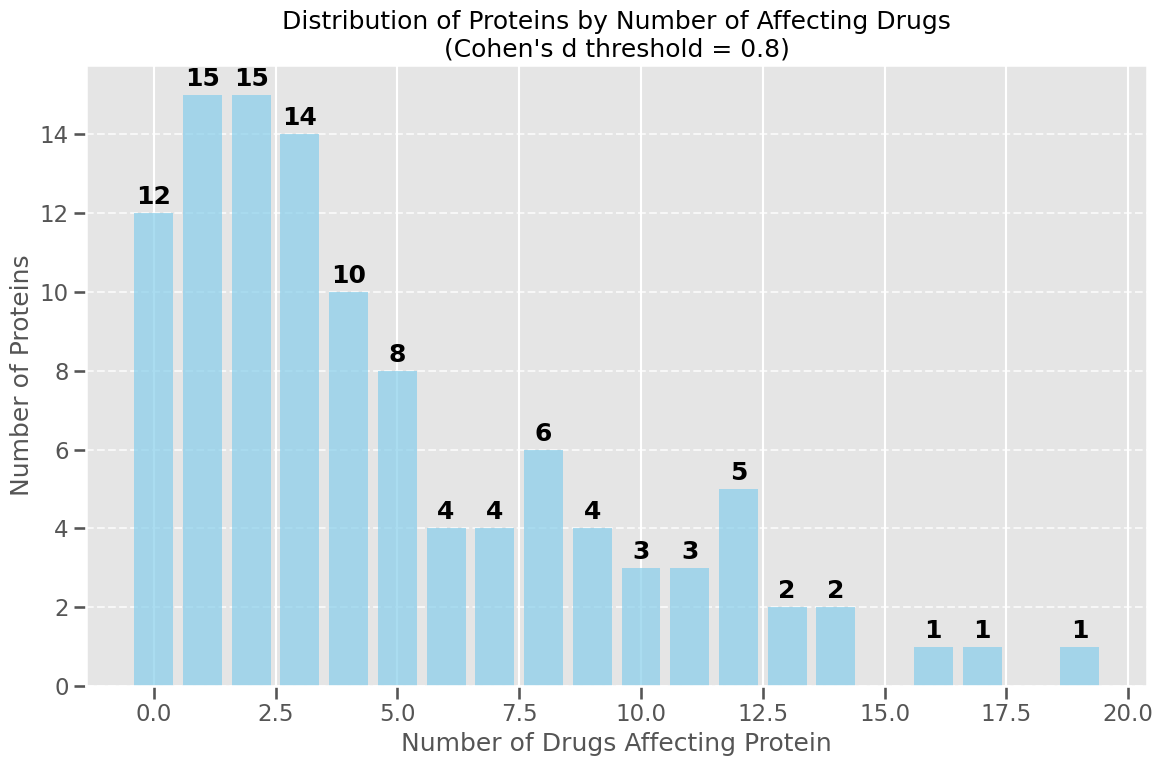


Summary Statistics:
Total proteins analyzed: 110
Average number of affecting drugs per protein: 4.84
Maximum drugs affecting a single protein: 19
Proteins affected by no drugs: 12

Effect Size Distribution (Significant Results):
Effect
large    532
Name: count, dtype: int64


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Set plot style
plt.style.use("ggplot")
sns.set_context("talk")


def get_drug_names(df: pd.DataFrame):
    """
    Extract sorted, unique drug names from column headers.
    Expects columns like "_dyn_#DRUG 10nM.Tech replicate…".
    """
    pattern = r"_dyn_#(?P<drug>[^ ]+) \d+nM"
    drugs = df.columns.to_series().str.extract(pattern)["drug"].dropna().unique()
    return sorted(drugs)


def process_protein_data(df: pd.DataFrame, min_samples=20):
    # Filter out rows where Proteins contain semicolons
    df_filtered = df[~df["Proteins"].str.contains(";", na=False)]

    # Count occurrences of each protein in descending order
    protein_counts = df_filtered["Proteins"].value_counts()

    # Filter proteins that appear in at least min_samples rows
    frequent_proteins = protein_counts[protein_counts >= min_samples]

    # Create a filtered dataset with only frequent proteins
    df_frequent = df_filtered[df_filtered["Proteins"].isin(frequent_proteins.index)]

    return df_frequent, frequent_proteins


def calculate_cohens_d(group1, group2):
    # Calculate Cohen's d statistic
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)

    # Pooled standard deviation
    pooled_std = np.sqrt(
        ((len(group1) - 1) * std1**2 + (len(group2) - 1) * std2**2)
        / (len(group1) + len(group2) - 2)
    )

    # Cohen's d
    d = (mean1 - mean2) / pooled_std if pooled_std != 0 else 0
    return d


def interpret_effect(d: float) -> str:
    ad = abs(d)
    if ad < 0.2:
        return "negligible"
    if ad < 0.5:
        return "small"
    if ad < 0.8:
        return "medium"
    return "large"


def analyze_drug_protein_interactions(df, variant_scores_df, cohens_d_threshold=0.8):
    proteins = df["Proteins"].unique()
    drugs = get_drug_names(df)

    print(f"Analyzing {len(proteins)} proteins against {len(drugs)} drugs...")

    # Dictionary to store count of drugs affecting each protein
    protein_affected_by_drugs = {protein: 0 for protein in proteins}
    all_results = []

    for protein in tqdm(proteins):
        protein_df = df[df["Proteins"] == protein]

        for drug in drugs:
            # Get variant scores for this drug
            drug_variant_scores = (
                variant_scores_df[variant_scores_df["drug"] == drug]["log_fold_change"]
                .dropna()
                .values
            )

            if len(drug_variant_scores) <= 1:
                continue

            # Get all columns for this drug
            drug_cols = [c for c in df.columns if f"_dyn_#{drug} " in c and "nM" in c]
            if not drug_cols:
                continue

            # Get all values for this drug across all concentrations
            drug_values = []
            for col in drug_cols:
                values = protein_df[col].dropna().values
                if len(values) > 0:
                    drug_values.extend(values)

            # Calculate Cohen's d if we have enough data
            if len(drug_values) > 1:
                d = calculate_cohens_d(np.array(drug_values), drug_variant_scores)
                effect = interpret_effect(d)

                # If Cohen's d exceeds threshold, count this drug as affecting the protein
                if abs(d) > cohens_d_threshold:
                    protein_affected_by_drugs[protein] += 1

                # Store detailed results
                all_results.append(
                    {
                        "Protein": protein,
                        "Drug": drug,
                        "Cohens_d": d,
                        "Effect": effect,
                        "Significant": abs(d) > cohens_d_threshold,
                        "Protein_samples": len(drug_values),
                        "Variant_score_samples": len(drug_variant_scores),
                    }
                )

    results_df = pd.DataFrame(all_results)
    return protein_affected_by_drugs, results_df


def plot_drugs_per_protein(protein_drug_counts, output_dir, cohens_d_threshold=0.8):
    # Convert to DataFrame for easier analysis
    df_counts = pd.DataFrame(
        {
            "protein_id": list(protein_drug_counts.keys()),
            "drugs_affecting": list(protein_drug_counts.values()),
        }
    )

    # Group by number of affecting drugs
    grouped = (
        df_counts.groupby("drugs_affecting").size().reset_index(name="protein_count")
    )

    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.bar(
        grouped["drugs_affecting"], grouped["protein_count"], color="skyblue", alpha=0.7
    )
    plt.xlabel("Number of Drugs Affecting Protein")
    plt.ylabel("Number of Proteins")
    plt.title(
        f"Distribution of Proteins by Number of Affecting Drugs\n(Cohen's d threshold = {cohens_d_threshold})"
    )
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Add values on top of bars
    for i, v in enumerate(grouped["protein_count"]):
        plt.text(
            grouped["drugs_affecting"].iloc[i],
            v + 0.1,
            str(v),
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # Save figure
    plt.tight_layout()
    output_path = os.path.join(
        output_dir, f"protein_affected_by_drugs_d{cohens_d_threshold}.png"
    )
    plt.savefig(output_path, dpi=300)
    plt.show()

    return df_counts


def main():
    # Set up paths and parameters
    input_file_path = "data/mq_variants_intensity_cleaned.csv"
    variant_scores_path = "data/variant_scores.csv"
    output_dir = "data/drug_distributions"
    results_output_path = "data/drug_protein_interaction_stats.csv"

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Load and process data
    print("Loading data...")
    df = pd.read_csv(input_file_path)
    variant_scores_df = pd.read_csv(variant_scores_path)
    df_filtered, protein_counts = process_protein_data(df)

    print(f"Processed {len(df_filtered)} rows with {len(protein_counts)} proteins...")

    # Analyze drug-protein interactions using variant scores
    protein_drug_counts, results_df = analyze_drug_protein_interactions(
        df_filtered, variant_scores_df
    )

    # Save detailed results
    results_df.to_csv(results_output_path, index=False)

    # Plot the results
    counts_df = plot_drugs_per_protein(protein_drug_counts, output_dir)

    # Show summary statistics
    print("\nSummary Statistics:")
    print(f"Total proteins analyzed: {len(counts_df)}")
    print(
        f"Average number of affecting drugs per protein: {counts_df['drugs_affecting'].mean():.2f}"
    )
    print(
        f"Maximum drugs affecting a single protein: {counts_df['drugs_affecting'].max()}"
    )
    print(f"Proteins affected by no drugs: {(counts_df['drugs_affecting'] == 0).sum()}")

    # Effect size summary
    effect_summary = results_df[results_df["Significant"]]["Effect"].value_counts()
    print("\nEffect Size Distribution (Significant Results):")
    print(effect_summary)


if __name__ == "__main__":
    main()